**Voorbereiding: Jupyter Notebook initialiseren**

In [ ]:
import sys
sys.path.append('D:/Python/Projecten/pypv')
sys.path.append('D:/Python/Projecten/pypv/lib')  # add my own lib folder to Python's search path
sys.path.append('D:/Python/Projecten/pypv/datafiles')  # also add the folder with the data files
sys.path.append('D:/Python/Projecten/pypv/scripts')  # and the folder that contains the script with the configuration of the PV system

In [2]:
from IPython.display import Image, HTML
import sun
import photovoltaic as pv
from quantities.date_time import Date, ANY_YEAR

`sun`, `photovoltaic` en `quantities` zijn drie zelf geschreven Python *packages* (*libraries*) die alle programmatuur bevatten om de computer de berekeningen te laten uitvoeren.
* `sun` bevat onder meer de programmacode om horizonprofielen, zonnebaandiagrammen en de zonnebestralingssterkte (irradiantie) op een oppervlak te berekenen.
* `photovoltaic` modelleert de componenten van een fotovoltaïsche installatie (o.a. zonnepaneel, zonnepanelenmatrix, omvormer) en de programmcode om een energieanalyse te maken.
* `quantities` is een secundaire *package* waarin fysische grootheden worden gemodelleerd (o.a. tijd, datum). 

# DEEL 3 | ENERGIEANALYSE

In deze *notebook* zal een schatting worden gemaakt van de hoeveelheid 'groene' elektrische energie die op jaarbasis kan verwacht worden van de FV installatie, rekening houdend met de horizonprofielen van de twee FV matrices op het platte dak van de woning en het rendement van de samenstellende onderdelen: zonnepanelen, bekabeling en omvormer.<br>
Vervolgens zal de zelfvoorzieningsgraad en de benuttingsgraad geëvalueerd worden. De zelfvoorzieningsgraad drukt uit hoeveel procent van het jaarlijks elektriciteitsverbruik geleverd wordt door de zonnepanelen. De benuttingsgraad drukt uit hoeveel procent van de jaarlijkse zonneopbrengst door de eigen elektrische installatie wordt verbruikt. De analyse wordt gemaakt, zowel zonder, als met opslagbatterij.<br>
Tot slot wordt nagegaan wat de financiële consequenties kunnen zijn als men opteert voor, ofwel een (digitale) energiemeter volgens het principe van de terugdraaiende teller en de betaling van een prosumententarief (de zgn. 'compensatieregeling'), ofwel een digitale energiemeter waarbij het distributienettarief wordt aangerekend op basis van de werkelijke hoeveelheid van het openbare net afgenomen elektriciteit.

De omvormer (`inverter`) die in deel 2, basisontwerp werd geconfigureerd en waaraan de FV matrices werden verbonden, moet in de werkomgeving van dit *notebook* opnieuw worden geïmporteerd. Ook de geografische locatie (`loc`) is opnieuw nodig. 

In [3]:
from energy_analysis_02 import inverter, loc

De energieanalyse wordt uitgevoerd door een `EnergyAnalyzer`-object. In de constructor wordt het pad opgegeven naar het bestand met de klimaatdata (`TMY_file`) en het pad naar het bestand met data over het elektriciteitsverbruik (`CLP_file`, *Consumer Load Profile*). Deze *csv*-bestanden moeten door de gebruiker voorbereid worden, zodat de `EnergyAnalyzer`deze correct zou interpreteren en kunnen verwerken.<br>
Een FV installatie kan meer dan één omvormer omvatten. De parameter `pv_inverters`verwacht daarom een lijst van minstens 1 of meer `Inverter` objecten.

In [4]:
ea = pv.EnergyAnalyzer(
    TMY_file='../datafiles/tmy.csv',
    CLP_file='../datafiles/mlp.csv',
    location=loc,
    pv_inverters=[inverter]
)

Het databestand <a href="/static/datafiles/tmy.csv" download="tmy.csv">tmy.csv</a> bevat de klimaatdata die afkomstig is uit de PVGIS 5 database. Het databestand <a href="/static/datafiles/mlp.csv" download="mlp.csv">mlp.csv</a> bevat de 'kwartierverbruiken' over een gans jaar. De vermelde tijdstippen zijn in de beide databestanden in UTC uitgedrukt. De verbruiken werden met een power analyzer gemeten. De meetcampagne duurde een drietal weken. De verzamelde data werd geëxtrapoleerd over een gans jaar, waarbij werd aangenomen dat het opgemeten weekprofiel zich zonder noemenswaardige variaties herhaalt.

**Energieanalyse laten uitvoeren...**

In [5]:
%time ea.analyze()

Wall time: 4min 30s


## Analyseresultaat 1: Opbrengst en Verbruik

### Geschatte Jaarlijkse Opbrengst van de FV Installatie

In [6]:
display(HTML(f'Geschatte jaarlijkse opbrengst = <b>{ea.get_annual_yield():.0f}</b> kWh'))

### Geschat Jaarlijks Verbruik van de Verbruikersinstallatie

In [7]:
display(HTML(f'Geschat jaarlijks verbruik = <b>{ea.get_annual_load():.0f}</b> kWh'))

### Opbrengst- en Verbruiksprofiel

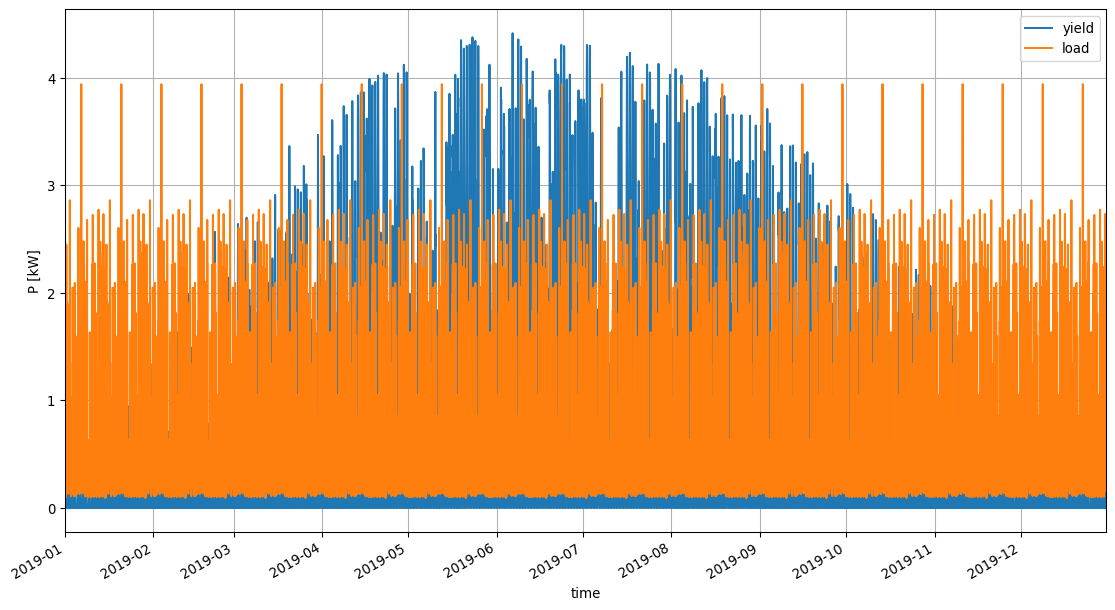

In [8]:
graph = ea.plot_profiles(fig_size=(14, 8), dpi=96)
graph.show_graph()

## Analyseresultaat 2: Energiestromen Zonder Batterijopslagsysteem

In een fotovoltaïsche installatie kunnen de volgende energiestromen (eenheid: kWh) onderscheiden worden:
* een energiestroom `Egtl` (*Grid to Load*) vanuit het net naar de verbruikersinstallatie (belasting) = netvoeding
* een energiestroom `Eptg` (*PV to Grid*) vanuit de FV installatie naar het net = netinjectie
* een energiestroom `Eptl` (*PV to Load*) vanuit de FV installatie naar de belasting = eigenverbruik
* in het geval van een batterijopslagsysteem: een energiestroom `Eptb` (*PV to Battery*) vanuit de FV installatie naar de batterij
* in het geval van een batterijopslagsysteem: een energiestroom `Ebtl` (*Battery to Load*) vanuit de batterij naar de belasting

Een energiestroom vanuit het net naar de batterij (*Grid to Battery*) wordt niet toegelaten. Doel van het batterijopslagsysteem dient om momentaan productieoverschot van de zonnepanelen op te slaan in de batterij voor later eigenverbruik i.p.v. het productieoverschot in het net te injecteren. Het kan evenwel niet de bedoeling zijn dat de batterij wordt bijgeladen vanuit het net.

### Maandelijks Overzicht van de Energiestromen

In het geval van een FV installatie zonder batterijopslagsysteem, bekomt het computerprogramma de volgende maandelijkse energiestromen:

In [9]:
display(HTML(ea.get_monthly_overview().to_html()))

,Egtl,Eptg,Eptl,Eptb,Ebtl
1,256.093581,33.843208,61.673482,0.0,0.0
2,199.551792,95.925242,86.366115,0.0,0.0
3,191.709604,279.079706,123.139329,0.0,0.0
4,155.748527,609.438008,148.139749,0.0,0.0
5,143.954194,611.026784,164.444962,0.0,0.0
6,138.822504,739.922093,168.512696,0.0,0.0
7,151.134437,650.715979,167.320621,0.0,0.0
8,154.354535,631.108177,156.410200,0.0,0.0
9,174.209156,400.303215,134.261764,0.0,0.0
10,206.840878,194.051593,106.741623,0.0,0.0


Dit kan ook overzichtelijk in een grafiek worden weergegeven:

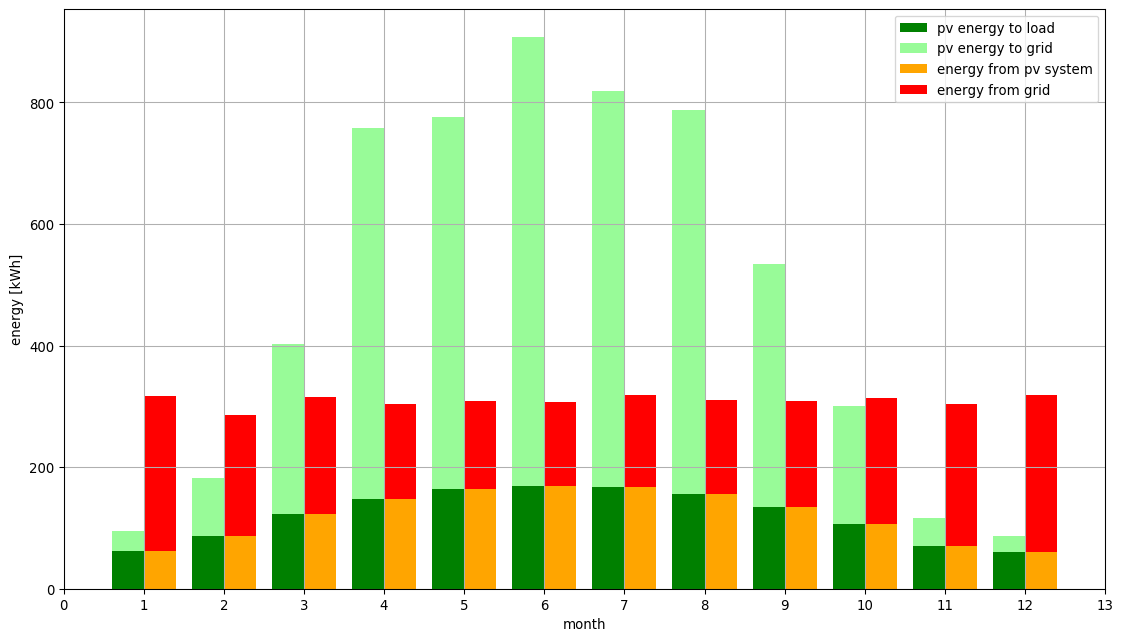

In [10]:
graph = ea.plot_monthly_overview(fig_size=(14, 8), dpi=96)

## Analyseresultaat 3: Zelfvoorziening en Zelfconsumptie Zonder Batterijopslagsysteem

* **Zelfvoorziening**: het elektrisch verbruik dat gedekt wordt door de eigen FV installatie. De *zelfvoorzieningsgraad* is het percentage van het jaarlijks verbruik dat geleverd wordt door de eigen FV installatie.
* **Zelfconsumptie** of **eigenverbruik**: de energieopbrengst van de FV installatie die door de eigen verbruikersinstallatie wordt benut. De *benuttingsgraad* van de FV installatie is het percentage van de jaarlijkse opbrengst dat door de eigen verbruikerinstallatie wordt benut.

### Zelfvoorzieningsgraad

In [11]:
display(HTML(f'Zelfvoorzieningsgraad op jaarbasis = <b>{ea.get_self_sufficiency():.2f}</b> %'))

*Maandelijks overzicht van de zelfvoorzieningsgraad*

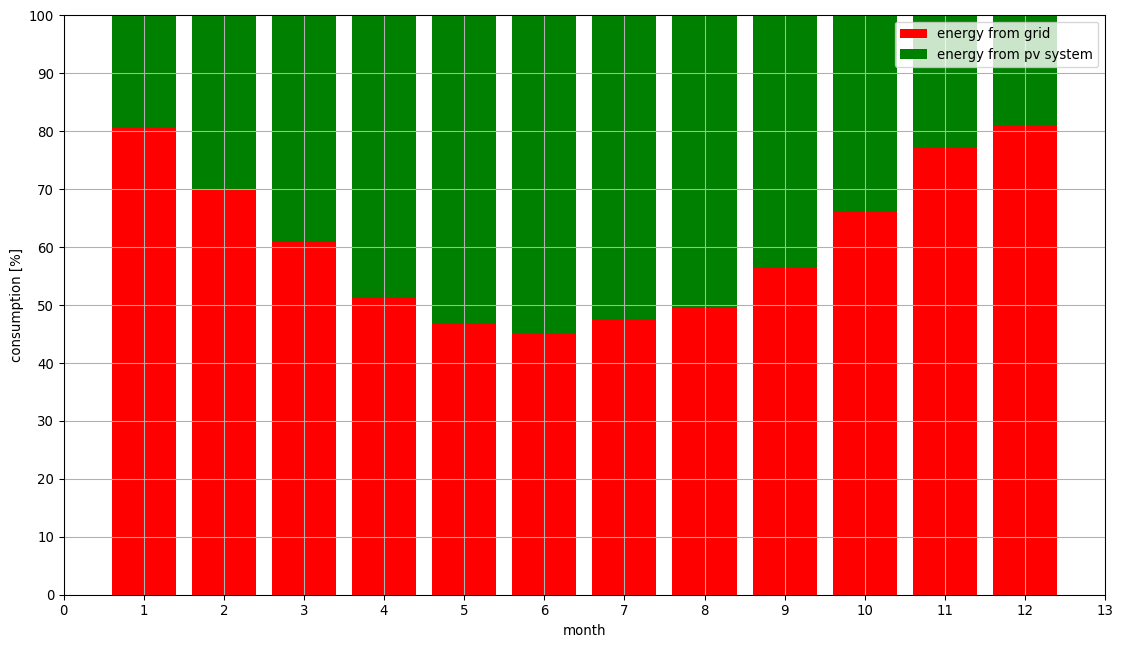

In [12]:
graph = ea.plot_self_sufficiency(fig_size=(14, 8), dpi=96)
graph.show_graph()

### Benuttingsgraad

In [13]:
display(HTML(f'Benuttingsgraad op jaarbasis = <b>{ea.get_self_consumption():.2f}</b> %'))

*Maandelijks overzicht van de benuttingsgraad*

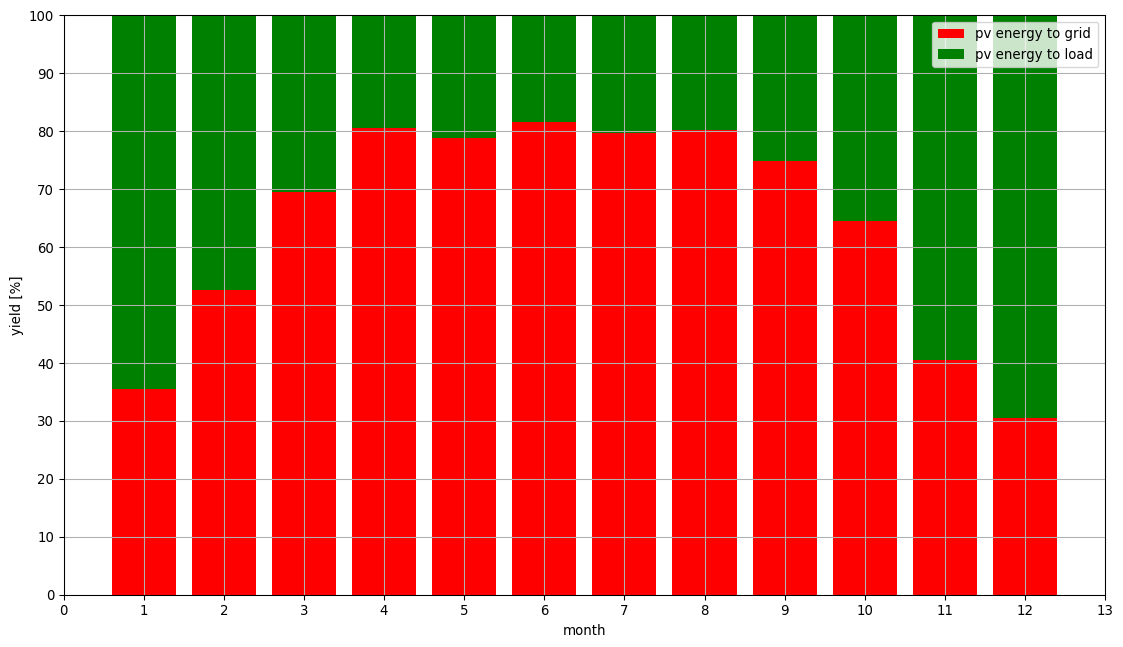

In [14]:
graph = ea.plot_self_consumption(fig_size=(14, 8), dpi=96)
graph.show_graph()

### Netto Netverbruik
In het geval van een terugdraaiende teller wordt het jaarlijks netto netverbruik aangerekend samen met een prosumententarief, dat afhangt van het nominaal AC-vermogen van de omvormer. Het netto netverbruik is het verschil tussen de hoeveelheid elektriciteit afgenomen van het net en de hoeveelheid elektriciteit die in het net werd geïnjecteerd.

In [15]:
display(HTML(f'Netto netverbruik = <b>{ea.get_net_consumption():.0f}</b> kWh'))

## Analyseresultaat 4: Energiestromen Met Batterijopslagsysteem

### Configuratie opslagbatterij

Een batterijopslagsysteem dient om energieopbrengsten die niet momentaan verbruikt kunnen worden in een batterij op te slaan voor later verbruik, m.n. vóór zonsopgang en na zonsondergang, wanneer er geen FV productie mogelijk is, vermits er dan geen zonnestraling is. Om de benodigde batterijcapaciteit te bepalen, zou men zich daarom kunnen baseren op verbruiksgegevens vóór zonsopgang en na zonsondergang.<br>
Aan het computerprogramma kan informatie worden opgevraagd over het dagelijks verbruik vóór zonsopgang en na zonsondergang (nachttijdverbruik): totaal jaarlijks nachttijdverbruik, het minimaal nachttijdverbruik dat voorkwam in het jaar, het gemiddeld nachttijdverbruik en het maximaal nachttijdverbruik.

In [16]:
nighttime_load_stats = ea.get_nighttime_load_stats()
display(HTML(
    '<ul>'
    f'<li>totaal jaarlijks nachttijdverbruik = <b>{nighttime_load_stats["sum"]:.0f}</b> kWh</li>'
    f'<li>minimum nachttijdverbruik = <b>{nighttime_load_stats["min"]:.0f}</b> kWh</li>'
    f'<li>gemiddeld nachttijdverbruik = <b>{nighttime_load_stats["avg"]:.0f}</b> kWh</li>'
    f'<li>maximum nachttijdverbruik = <b>{nighttime_load_stats["max"]:.0f}</b> kWh</li>'
    '</ul>'
))

Op basis van deze data kan een opslagbatterij geselecteerd worden. Als we ons baseren op het gemiddeld nachttijdverbruik, hebben we een batterij nodig met een benutbare batterijcapaciteit van ca. 5 kWh.<br>
<br>
De benutbare batterijcapaciteit zal evenwel afhangen van de ontlaad- en laadstroom van de batterij. Hiernavolgend is een zoutwaterbatterij GREENROCK in aanmerking genomen. Eén *stack* heeft volgens de datasheet bij een laadstroom van 10 A (ca. 560 W bij laadspanning 56 V) en een ontlaadstroom van 15 A (ca. 720 W bij een ontlaadspanning van 48 V) een beschikbare capaciteit van 1,676 kWh. We zullen daarom 3 *stacks* nemen.<br>
Indien het momentaan vermogen van de FV installatie groter zou zijn dan het vermogen dat de batterij kan accepteren, wordt het geaccepteerd vermogen begrensd tot wat de batterij aankan. Evenzo, indien het momentaan vermogen dat de verbruikersinstallatie vraagt, groter zou zijn dan hetgeen de batterij kan leveren, wordt het aan de batterij onttrokken vermogen eveneens begrensd tot wat de batterij aankan.   

**Configuratie opslagbatterij**

In [17]:
ea.battery = pv.Battery(battery_capacity=3 * 1.676)          # available battery capacity depending on load and unload current (see battery specs)
ea.battery.set_loading_params(Idc=10.0, Vdc=56.0, eff=0.9)   # battery current, load voltage and efficiency when loading
ea.battery.set_unloading_params(Idc=15.0, Vdc=48.0, eff=0.9) # battery current, load voltage and efficiency when unloading

### Maandelijks Overzicht van de Energiestromen

In [18]:
Eflow_stats = ea.analyze_energy_flows()
display(HTML(ea.get_monthly_overview().to_html()))

,Egtl,Eptg,Eptl,Eptb,Ebtl
1,222.250373,0.000000,61.673482,33.843208,33.843208
2,118.892719,15.266169,86.366115,80.659074,80.659074
3,44.244112,131.614214,123.139329,147.465492,147.465492
4,17.469874,471.159355,148.139749,138.278653,138.278653
5,10.631851,475.510714,164.444962,135.516070,133.322343
6,6.655389,608.104506,168.512696,131.817586,132.167116
7,12.654222,514.079960,167.320621,136.636019,138.480216
8,14.122640,490.876282,156.410200,140.231895,140.231895
9,32.167461,258.261520,134.261764,142.041695,142.041695
10,90.191650,77.402365,106.741623,116.649228,116.649228


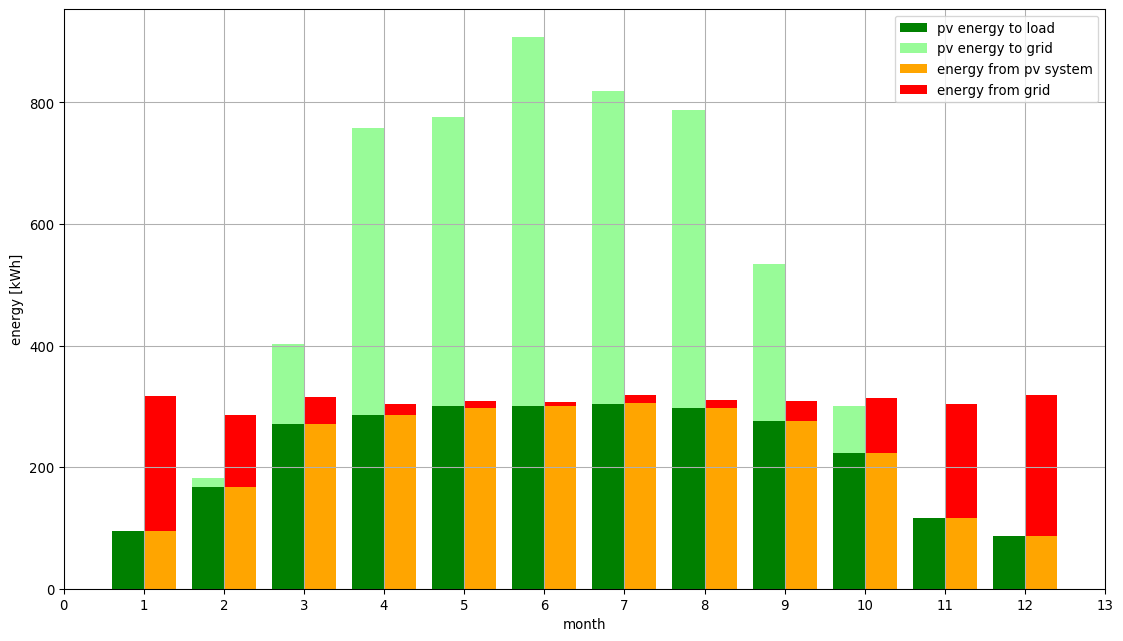

In [19]:
graph = ea.plot_monthly_overview(fig_size=(14, 8), dpi=96)
graph.show_graph()

## Analyseresultaat 5: Zelfvoorziening en Zelfconsumptie Met Batterijopslagsysteem

### Zelfvoorzieningsgraad

In [20]:
display(HTML(f'Zelfvoorzieningsgraad op jaarbasis = <b>{ea.get_self_sufficiency():.2f}</b> %'))

*Maandelijks overzicht van de zelfvoorzieningsgraad*

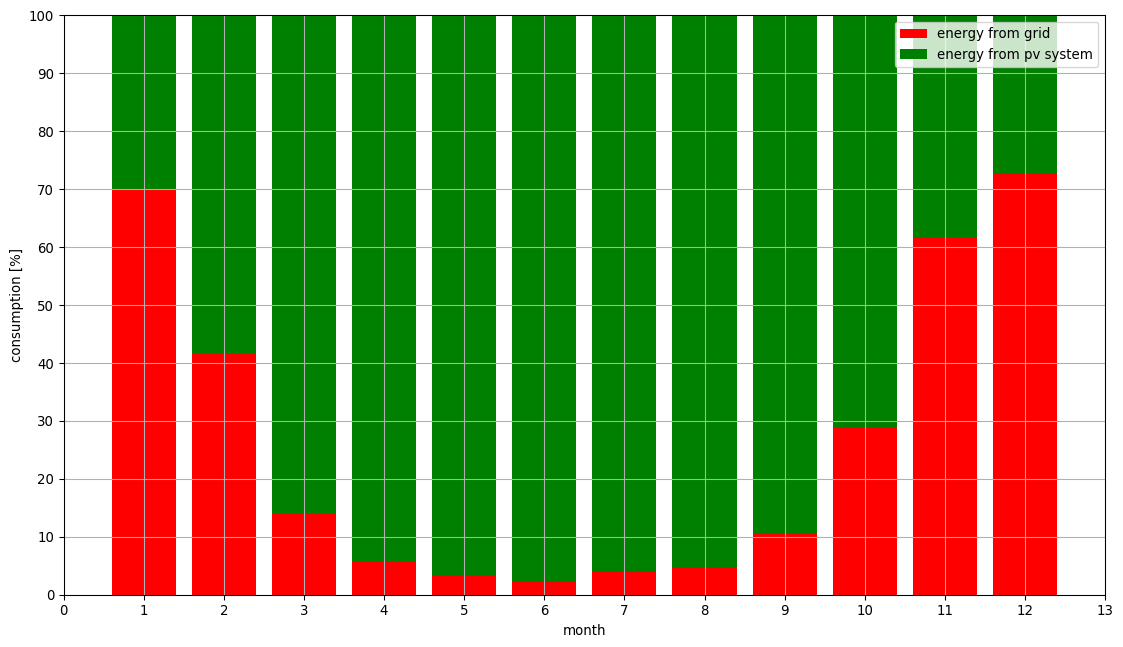

In [21]:
graph = ea.plot_self_sufficiency(fig_size=(14, 8), dpi=96)
graph.show_graph()

### Benuttingsgraad

In [22]:
display(HTML(f'Benuttingsgraad op jaarbasis = <b>{ea.get_self_consumption():.2f}</b> %'))

*Maandelijks overzicht van de benuttingsgraad*

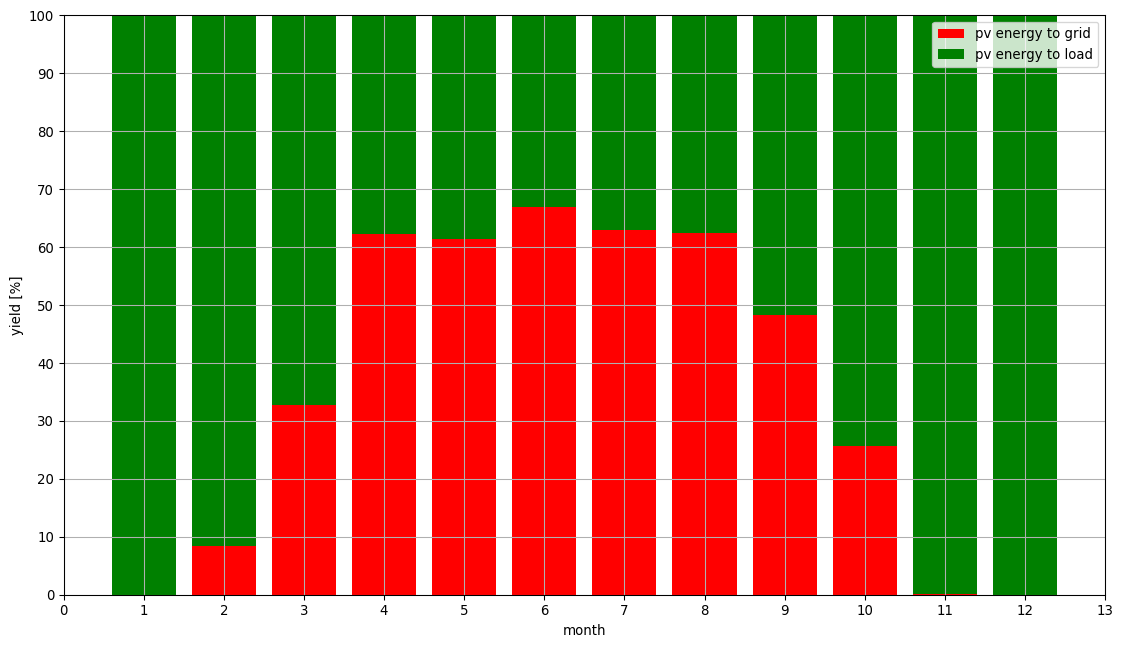

In [23]:
graph = ea.plot_self_consumption(fig_size=(14, 8), dpi=96)
graph.show_graph()

### Zelfvoorzieningsgraad i.f.v. Batterijcapaciteit

Men zou aannemen dat de zelfvoorzieningsgraad van een private elektrische installatie met zonnepanelen zal toenemen naarmate de batterijcapaciteit groter wordt gekozen.<br>
Hieronder wordt de zelfvoorzieningsgraad van de desbetreffende installatie berekend voor verschillende batterijcapaciteiten gaande van 1 kWh tot 25 kWh en weergegeven in een grafiek.

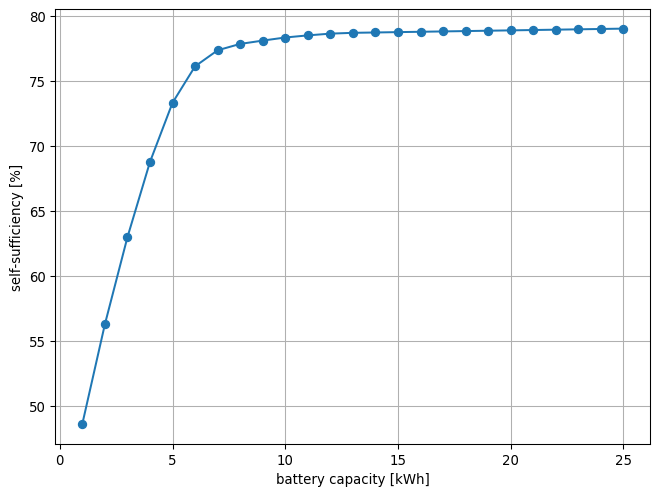

In [24]:
from nummath import graphing

battery_capacities = [i for i in range(1, 26)]
self_sufficiency = []
for battery_capacity in battery_capacities:
    ea.battery = pv.Battery(battery_capacity)
    ea.analyze_energy_flows()
    self_sufficiency.append(ea.get_self_sufficiency())

graph = graphing.Graph(fig_size=(8, 6), dpi=96)
graph.add_data_set(name='none', x=battery_capacities, y=self_sufficiency, marker='o')
graph.set_axis_titles(x_title='battery capacity [kWh]', y_title='self-sufficiency [%]')
graph.turn_grid_on()
graph.draw_graph()
graph.show_graph()

Men constateert dat de curve een verzadigend verloop vertoont. Aanvankelijk neemt de zelfvoorzieningsgraad steil toe, maar vanaf een batterijcapaciteit van ca. 5 kWh buigt deze tendens zich om en vanaf ca. 10 kWh wordt de curve nagenoeg vlak. Het heeft bijgevolg geen zin om batterijen te installeren met een beschikbare batterijcapaciteit die groter is dan 10 kWh.